# Bitcoin & Twitter

In [1]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import *
from pyspark.sql.functions import col, desc, asc, lit
from pyspark.sql import functions as F
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc
import re
import yfinance as yf
import datetime
import folium
from geopy.geocoders import Nominatim

from pattern.en import sentiment

sc = SparkContext("local").getOrCreate()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)
plt.style.use('ggplot')

21/11/19 16:59:13 WARN Utils: Your hostname, pop-os resolves to a loopback address: 127.0.1.1; using 192.168.0.4 instead (on interface enx00e04f7105c2)
21/11/19 16:59:13 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/11/19 16:59:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/19 16:59:14 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
21/11/19 16:59:14 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


## Data Exploration

### BITCOIN

 - Unix Timestamp - Date represented as epoc value
 - Date - date and time when the data point was collected
 - Symbol - Symbol of the currency
 - Open - Open value of the currency
 - High - Highest value of currency in the given minute
 - Low - Lowest value of currency in the given minute
 - Close - Close value of the currency in the given minute
 - Volume - Volume of the currency transacted in the given minute.

### TWITTER

 - user_name    The name of the user, as they’ve defined it.
 - user_location    The user-defined location for this account’s profile.
 - user_description	The user-defined UTF-8 string describing their account.
 - user_created	Time and date, when the account was created.
 - user_followers	The number of followers an account currently has.
 - user_friends	The number of friends a account currently has.
 - user_favourites	The number of favorites a account currently has
 - user_verified    When true, indicates that the user has a verified account
 - date UTC time and date when the Tweet was created
 - text The actual UTF-8 text of the Tweet
 - hashtags	All the other hashtags posted in the tweet along with #Bitcoin & #btc
 - source   Utility used to post the Tweet, Tweets from the Twitter website have a source value - web
 - is_retweet	Indicates whether this Tweet has been Retweeted by the authenticating user.

In [2]:
tweets_schema = StructType([
    StructField('user_name', StringType(), True),
    StructField('user_location', StringType(), True),
    StructField('user_description', StringType(), True),
    StructField('user_created', StringType(), True),
    StructField('user_followers', FloatType(), True),
    StructField('user_friends', FloatType(), True),
    StructField('user_favourites', FloatType(), True),
    StructField('user_verified', BooleanType(), True),
    StructField('date', StringType(), True),
    StructField('text', StringType(), True),
    StructField('hashtags', StringType(), True),
    StructField('source', StringType(), True),
    StructField('is_retweet', BooleanType(), True),
])


tweets_df = spark.read.csv(
    "./data/tweets.csv", 
    header=True,
    sep=',',
    multiLine=True,
    unescapedQuoteHandling="STOP_AT_CLOSING_QUOTE",
    schema=tweets_schema
)


In [3]:
# tweets_df = tweets_df.withColumn("date", datetime.datetime.strptime(str(col('date')), '%Y-%m-%d').strftime('%d/%m/%y')).filter((tweets_df.date > datetime.datetime(2020, 3, 20) )& (tweets_df.date < datetime.datetime(2021,9,10)))
tweets_df = tweets_df.withColumn("date", F.to_date(F.col("date"))).filter((tweets_df.date > datetime.datetime(2020, 3, 20) )& (tweets_df.date < datetime.datetime(2021,9,10)))
btc_stock=yf.Ticker("BTC-USD")
start = tweets_df.agg({"date": "min"}).collect()[0]
end = tweets_df.agg({"date": "max"}).collect()[0]

btc_stock = btc_stock.history(start=start['min(date)'], end=end['max(date)'])
btc_df = spark.createDataFrame(btc_stock)


## TWITTER

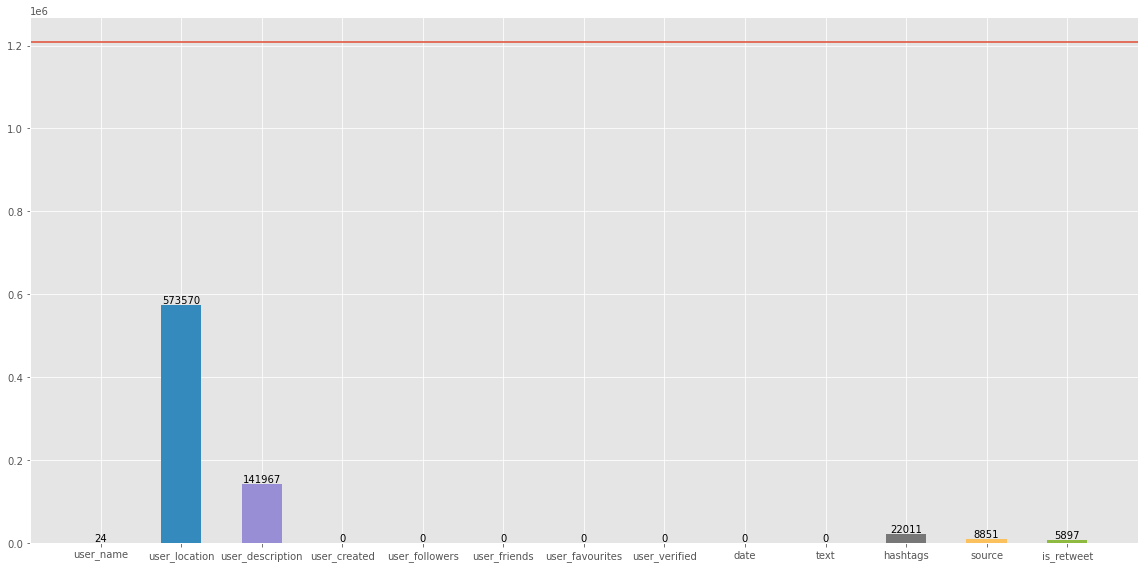

In [6]:
rows_count = tweets_df.count()

fig, ax = plt.subplots(figsize=(16,8))

df_labels = tweets_df.columns
width = 0.50  # the width of the bars

ax.axhline(y=rows_count, label="Total amount of rows")

for i, v in enumerate(df_labels):
	ax.bar_label(
		ax.bar(i, tweets_df.where(col(v).isNull()).count(), width)
	)

ax.set_xticks(range(len(df_labels)))
ax.set_xticklabels(df_labels)

fig.tight_layout()
plt.show()

## Preparing Data    Date|
+-------+-------------+

In [ ]:
from pyspark.sql.functions import udf

def conv_to_int(val):
    if isinstance(val, str):
        return 0
    else:
        return float(val)

conv_to_int_udf = udf(lambda x : conv_to_int(x), IntegerType())

tweets_df = tweets_df.withColumn("user_followers", conv_to_int_udf(col("user_followers")))\
    .withColumn("user_friends", conv_to_int_udf(col("user_friends")))\
    .withColumn("user_favourites", conv_to_int_udf(col("user_favourites")))

### Text cleaning

In [ ]:
def clean_text(text):
    if(isinstance(text, str)):
        text = text.replace("#","")
        text = re.sub('\\n', '', text)
        text = re.sub('https:\/\/\S+', '', text)
        return text
    else:
        return ""

clean_text_udf = udf(lambda x : clean_text(x), StringType())

tweets_df.withColumn("text", clean_text_udf(col("text")))

### Generating impact score

In [ ]:
from pyspark.sql.functions import struct

def generate_impact_score(tweet):
    coef_verified = 1.1 if tweet.user_verified else 1
    coef_hashtags = 1+(tweet.hashtags_len/20)
    return ((tweet.user_followers + (tweet.user_friends/4))*coef_verified*coef_hashtags)/100

generate_impact_score_udf = udf(lambda x : generate_impact_score(x), FloatType())

tweets_df.withColumn("impact_score", generate_impact_score_udf(struct([tweets_df[x] for x in tweets_df.columns])))

## Data visualisation

### Twitter

### Tweets / user

In [ ]:
%matplotlib inline

user_volume = tweets_df.groupby("user_name").count().sort(desc("count"))

n = 10
x_rows = user_volume.limit(n).select("user_name").collect()
x = list(map(lambda r : str(r['user_name']), x_rows))

y_rows = user_volume.limit(n).select("count").collect()
y = list(map(lambda r : int(r['count']), y_rows))

rc('figure', figsize=(25, 15))
fig, ax = plt.subplots()
ax.plot(x, y,
        label='tweets per user')

ax.set_xlabel('username')
ax.set_ylabel('# tweets')
ax.legend()

### Bitcoin Value

In [ ]:
# df_location = tweets_df.groupBy('user_location').count().sort(col("count").desc()).show()
geolocator = Nominatim(user_agent="example")
location_df = tweets_df.groupBy('user_location').count().filter("count >= 500").where("user_location not in ('Decentralized', 'Moon', '🇦🇺', 'Everywhere', 'Road Warrior', 'Mars', 'Cloud Engineer', 'Planet Earth', 'Earth', 'Blockchain', 'The Blockchain')").sort(col("count").desc()).dropna().collect()

def coords(location_string):
    try:
        location_obj = geolocator.geocode(location_string).raw
        return (location_obj['lat'], location_obj['lon'])
    except:
        return (20, 20)

locations = list(map(lambda r : [r['user_location'], r['count'], coords(r['user_location']) ], location_df)) 
map_tweets = folium.Map(location=[65,26], zoom_start=4)

for location_name, count, location_coords in locations:
    folium.Circle(location=location_coords,
                  popup = f"{location_name}: {count}",
                  radius = count*50,
                  color="crimson",
                  fill_color="crimson",
                  tooltip=count).add_to(map_tweets)
map_tweets

In [ ]:
date_df = tweets_df.withColumn("date", F.to_date(F.col("date")))
date_df = date_df. groupby("date").count().dropna().sort(asc("date")).filter((date_df.date > datetime.datetime(2020, 3, 20) )& (date_df.date < datetime.datetime.today()))
date_df.sort(desc("date")).show(1)
date_df.sort(asc("date")).show(1)
x_rows = date_df.select("date").collect() 
x = list(map(lambda r : (r['date']), x_rows)) 
y_rows = date_df.select("count").collect() 
tweets_y = list(map(lambda r : int(r['count']), y_rows))

In [ ]:
y_rows = btc_df.select("Volume").collect() 
btc_y = list(map(lambda r : float(r['Volume']), y_rows))

In [ ]:
print(btc_df.select("Volume").count())
print(len(tweets_y))

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(x,tweets_y,label='Tweet Volume')
ax.set_yscale('log')
ax.tick_params(axis='y')
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=0)

plt.show()

In [ ]:
fig, ax2 = plt.subplots(figsize=(16,8))
ax2.plot(btc_y,color='orange',label='Volume')
ax2.set_yscale('log')
ax2.tick_params(axis='y')

lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines2,labels2, loc=0)
plt.show()

In [ ]:
tweet_text = tweets_df.select("text").collect()

sentiments = [(x.text, *sentiment(x.text)) for x in tweet_text]

print(*sentiments[0:30], sep='\n')